# Utils

In [1]:
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import glob
from collections import defaultdict
from collections import OrderedDict
import seaborn as sns
from scipy import stats
# AXIS_FONT_SIZE=17
# plt.close('all')
# plt.style.use('default')
# plt.rc('text', usetex=True)
# plt.rc('font', size=AXIS_FONT_SIZE)
# plt.rc('legend', fontsize=AXIS_FONT_SIZE)
# plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
#plt.rcParams['figure.figsize'] = [12, 5]
#plt.rcParams['figure.figsize'] = [6.4, 4.8]

def read_csv(path, substrings=None, max_iters=None):
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    if substrings is not None:
        for substring in substrings:
            filenames = [f for f in filenames if substring in f ]
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(filename, engine='python').select_dtypes(['number']) for filename in filenames]
    # Make sure that all dfs have the same number of trajectories
    if max_iters is not None:
        dfs_list = [df[:max_iters] for df in dfs_list]
    return dfs_list, filenames
    
    
def create_average_df(path, substrings=None, max_iters=None, kpis=None):
    
    dfs_list, filenames = read_csv(path, substrings, max_iters)
    # Adding the filename to each dataframe
    for df, filename in zip(dfs_list, filenames):
      df['Filename'] = filename
    # Combine the list of dataframes, on top of each other
    combo_df = pd.concat(dfs_list, ignore_index=True, sort=False)
    if kpis is None:
        # Set kpis equal to the list of column names except 'Filename'
        kpis = combo_df.columns[:-1]
    n_files = len(filenames)
    means = defaultdict(list)
    for kpi in kpis:
        for it in range(max_iters):
            means[kpi].append(np.array([combo_df[kpi][it + f*max_iters] for f in range(n_files)]).mean())
    df_out = pd.DataFrame.from_dict(means)
    return df_out, filenames, combo_df, dfs_list

def extract_float(s):
    # Extract numbers from garbage string:
    newstr = ''.join((ch if ch in '0123456789.-e' else ' ') for ch in str(s))
    listOfNumbers = [float(i) for i in newstr.split()]
    listOfNumbers = listOfNumbers[0]
    return listOfNumbers

def clean_df(df, str_columns):
    # Transform string columns into floats if there is any 
    fu = lambda x: extract_float(x)
    for column in str_columns:
        df[column] = pd.Series(list(map(extract_float, df[column].astype(str).values)))
    return df

def clean_csv(path, str_columns):
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(f) for f in filenames]
    for df, filename in zip(dfs_list, filenames):
        df = clean_df(df, str_columns)
        df.to_csv("{}".format(filename))
    return dfs_list

def plot_data(path, key='ReturnLastEpisode'):
    df = pd.read_csv(path)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mean = df[key]
    ax.plot(df['Iteration'], mean)
    return fig

def plot_all(dfs, key='AvgRet', ylim=None, scale='Iteration'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for df in dfs:
        value = df[key]
        ax.plot(df[scale+'SoFar'], value)
    return fig

def compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None,
            scale='Iteration', title=None, xlabel=None, ylabel=None, grid=True, legend_position='upper left', alpha=1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    entries = []
    colors = ["lime", "blue", "orange"]
    for n, candidate_name in enumerate(candidates):
        entries.append(candidate_name)
        dfs = candidates[candidate_name]
        n_runs = len(dfs)
        mean_df, std_df = moments(dfs)
        mean = mean_df[key]
        std = std_df[key]
        ax.plot(mean_df[scale], mean, alpha=alpha, color=colors[n])
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3, color=colors[n])
        print(candidate_name, end=': ')
        print_ci(dfs, conf, key)
    ax.legend(entries, loc=legend_position)
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=AXIS_FONT_SIZE)
        if ylabel is None:
            plt.ylabel(key, fontsize=AXIS_FONT_SIZE)
        else:
            plt.ylabel(ylabel, fontsize=AXIS_FONT_SIZE)
    if grid: plt.grid(linestyle='--', linewidth=0.5)
    return fig

# Calculate, plot and save confidence intervals

def moments(dfs):
    concat_df = pd.concat(dfs, axis=1)
    mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
    std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()
    return mean_df, std_df

def plot_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration',
            title=None, grid=True, xlabel=None, ylabel=None, yticks=True):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if isinstance(scale, str):
        ax.plot(mean_df[scale], mean)
    else: # it is possiple to pass a list of ordinates
        ax.plot(scale, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    if isinstance(scale, str):
         ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
    else: # it is possiple to pass a list of ordinates
        ax.fill_between(scale, interval[0], interval[1], alpha=0.3)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=AXIS_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=AXIS_FONT_SIZE)
            
    if ylim: ax.set_ylim(ylim)
    if title is None:
        title = key
        ax.set_title(title)
    elif title is 'no':
        pass
    else:
        title = key + ' - ' + title
    if grid: plt.grid(linestyle='--', linewidth=0.5)
    if not yticks:
        from matplotlib.ticker import NullFormatter
        ax.yaxis.set_major_formatter(NullFormatter())
    return fig

def print_ci(dfs, conf=0.95, key='ReturnLastEpisode'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    total_horizon = len(mean_df)
    mean = mean_df[key][len(mean_df)-1]
    std = std_df[key][len(mean_df)-1]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    print('%f \u00B1 %f\t[%f, %f]\t total horizon: %d' % (mean, std, interval[0], interval[1], int(total_horizon)))

def save_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', horizon=1000, filename='prova.csv'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    low = pd.Series(interval[0])
    high = pd.Series(interval[1])
    iteration = pd.Series(horizon*np.array(range(len(mean))))
    df_out = pd.DataFrame(list(zip(iteration, mean, std, low, high)), columns=['iteration', 'mean', 'std', 'low', 'up'])
    df_out.to_csv(filename, index=False)
    
def find_max(dfs_list, key):
    maximum = 0
    for df in dfs_list:
        maximum_i = df['ReturnMax'].max()
        if maximum_i > maximum:
            maximum = maximum_i
    return maximum

def save_plot(fig, dir='.', fname='test'):
    fname = dir + '/' + fname + '.pdf'
    fig.savefig(fname, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
    return

def rename_column(old_name, new_name, dfs_lists):
    for dfs_list in dfs_lists:
        for df in dfs_list:
            df.rename(columns={old_name:new_name}, inplace=True)
    return dfs_lists

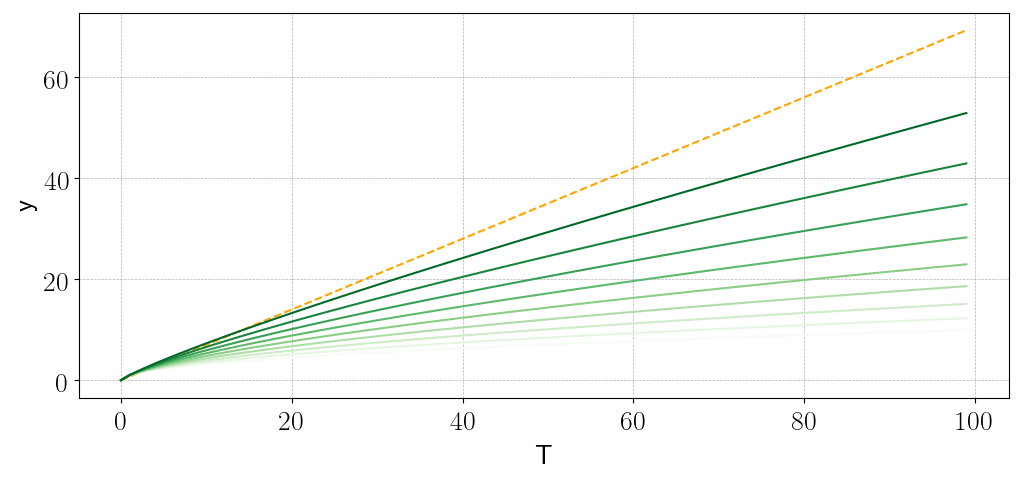

In [3]:
from matplotlib.pyplot import cm

AXIS_FONT_SIZE=20 #17
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [12, 5]

x = range(100)
y1 = [float*0.7 for float in x]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y1, '--', color="orange")

color=iter(cm.Greens(np.linspace(0,1,10)))
for i in range(9):
    c=next(color)
    y2 = np.sqrt(x)**(1 + i/11)
    ax.plot(x, y2, color=c)

plt.xlabel('T', fontsize=AXIS_FONT_SIZE)
plt.ylabel('y', fontsize=AXIS_FONT_SIZE)
plt.grid(linestyle='--', linewidth=0.5)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Presentation/Images', fname='sublinear')

# LQG - 1D

## Mu only

OPTIMIST: 414.427886 ± 93.853563	[378.727900, 450.127872]	 total horizon: 5000
UCB1: 657.429135 ± 135.051932	[606.999915, 707.858355]	 total horizon: 5000
GPUCB: 138.101587 ± 73.000832	[110.842628, 165.360546]	 total horizon: 5000


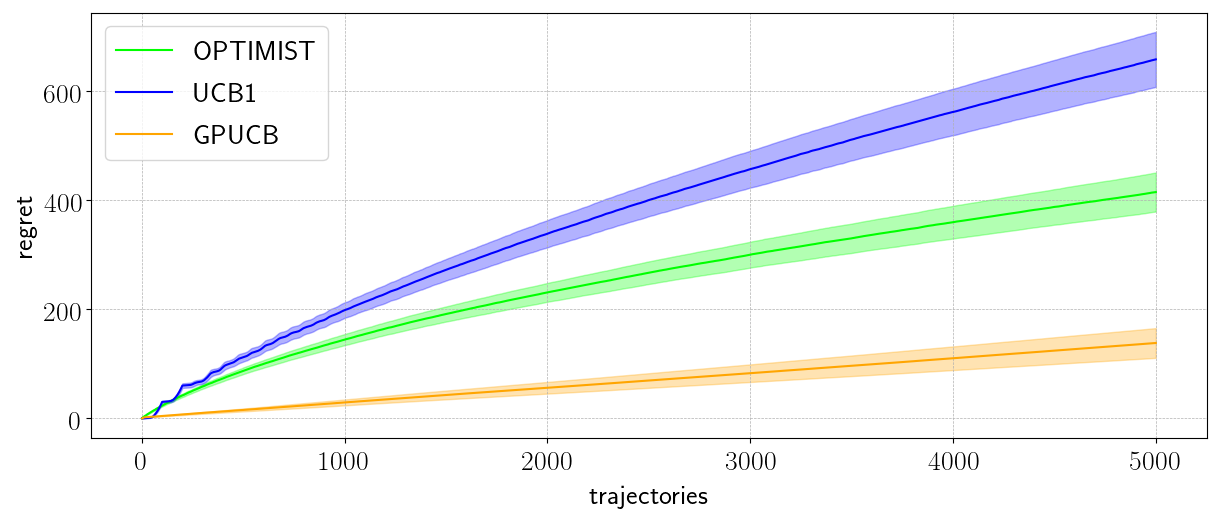

In [97]:
AXIS_FONT_SIZE=20 #17
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [12, 5]

path_opt ="./paper_plots/optimist_lqg/L*"
path_gpucb ="./paper_plots/gpucb_lqg/g*"
path_ucb1 ="./paper_plots/ucb1_lqg/u*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
dfs_list_gpucb, filenames_gpucb = read_csv(path_gpucb)
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
dfs_list_gpucb, dfs_list_opt, dfs_list_ucb1 = rename_column('LQGmu1_higher', 'mu', [dfs_list_gpucb, dfs_list_opt, dfs_list_ucb1])
candidates = OrderedDict({'OPTIMIST': dfs_list_opt, 'UCB1': dfs_list_ucb1, 'GPUCB': dfs_list_gpucb})
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories', ylabel='regret')
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Presentation/Images', fname='LQGcomparison')
# fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories')
# fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration', alpha=0.5)
# fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

In [54]:
dfs_list_gpucb[0].columns

Index(['LQGmu1_actor', 'Iteration', 'ReturnMean', 'ReturnLastEpisode',
       'TimeElapsed', 'Regret', 'Regret/t', 'mu', 'LQGsigma_higher'],
      dtype='object')

/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


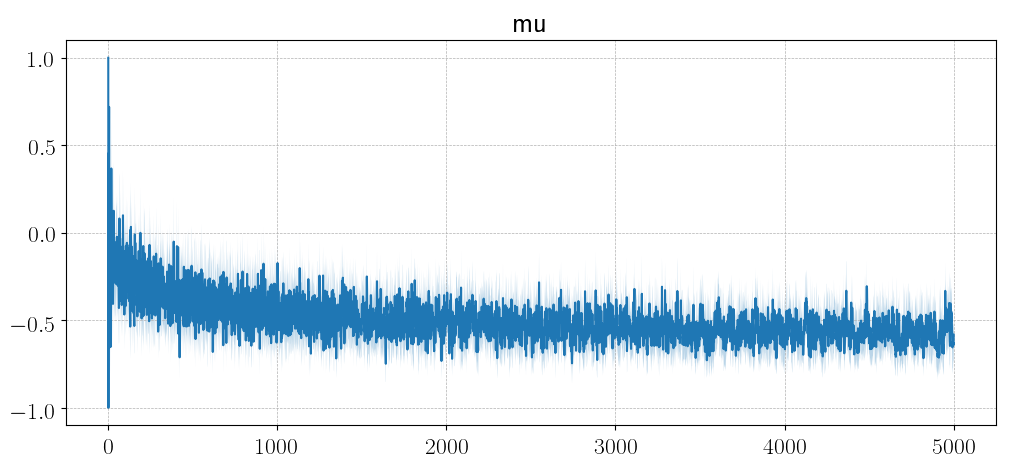

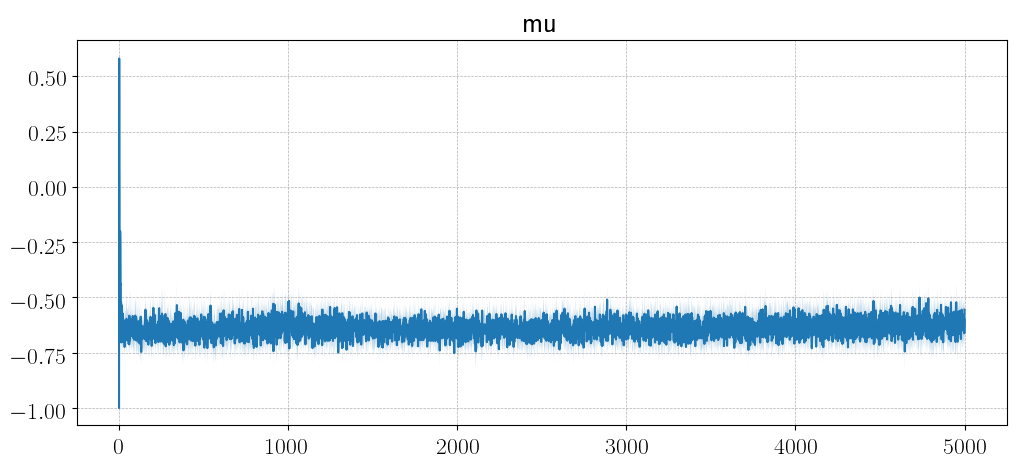

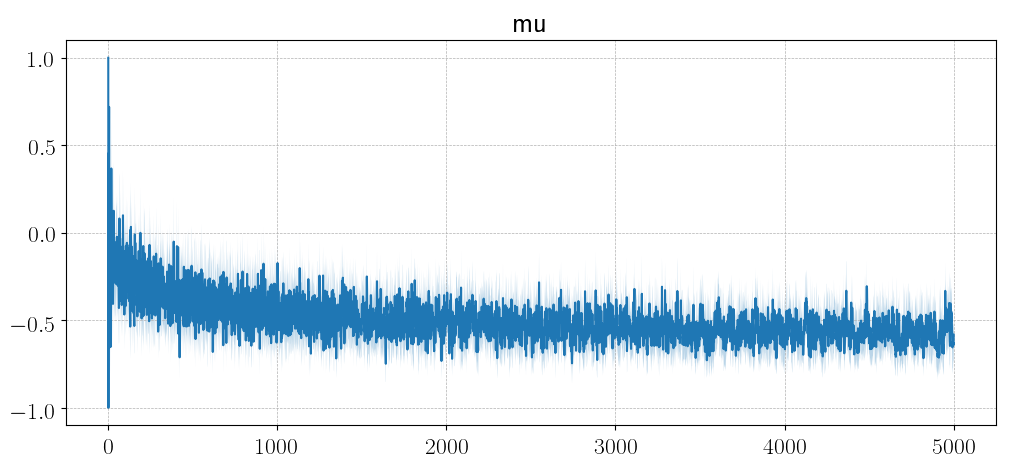

In [6]:
plot_ci(conf=0.95,dfs=dfs_list_gpucb, key='mu')
plot_ci(conf=0.95,dfs=dfs_list_opt, key='mu')

/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


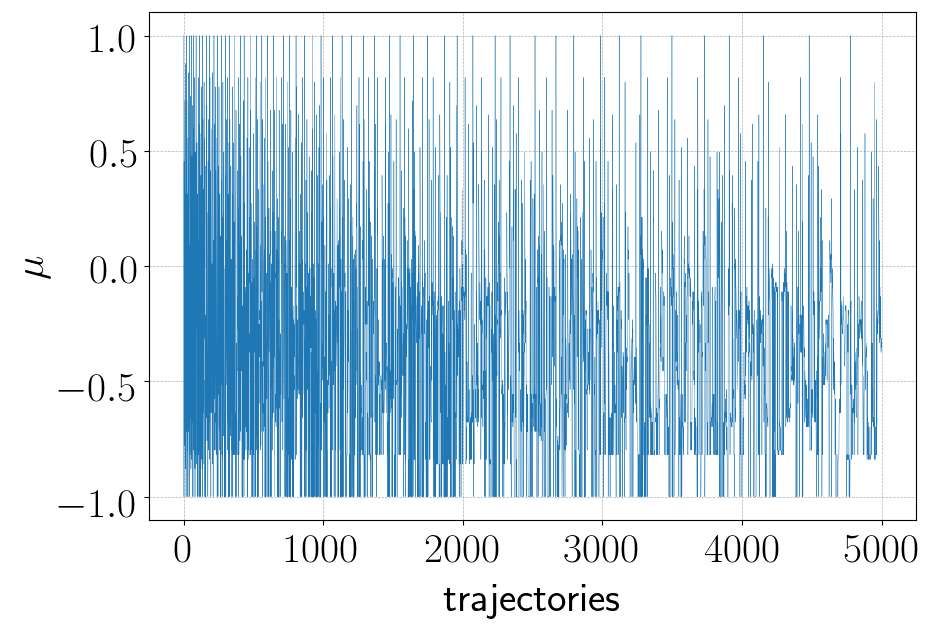

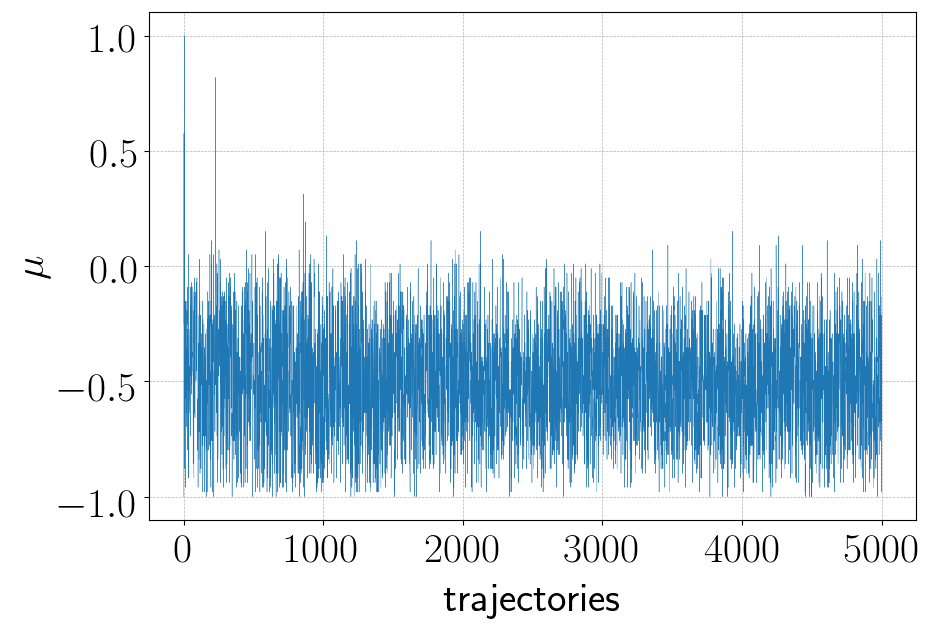

In [47]:
AXIS_FONT_SIZE=30
LINE_WIDTH=0.3
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('trajectories')
plt.ylabel('$\mu$')
ax.plot(dfs_list_opt[0]['Iteration'], dfs_list_opt[0]['mu'], linewidth=LINE_WIDTH)
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQG_OPTIMIST_mu')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('trajectories')
plt.ylabel('$\mu$')
ax.plot(dfs_list_gpucb[0]['Iteration'], dfs_list_gpucb[0]['mu'], linewidth=LINE_WIDTH)
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQG_GPUCB_mu')


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


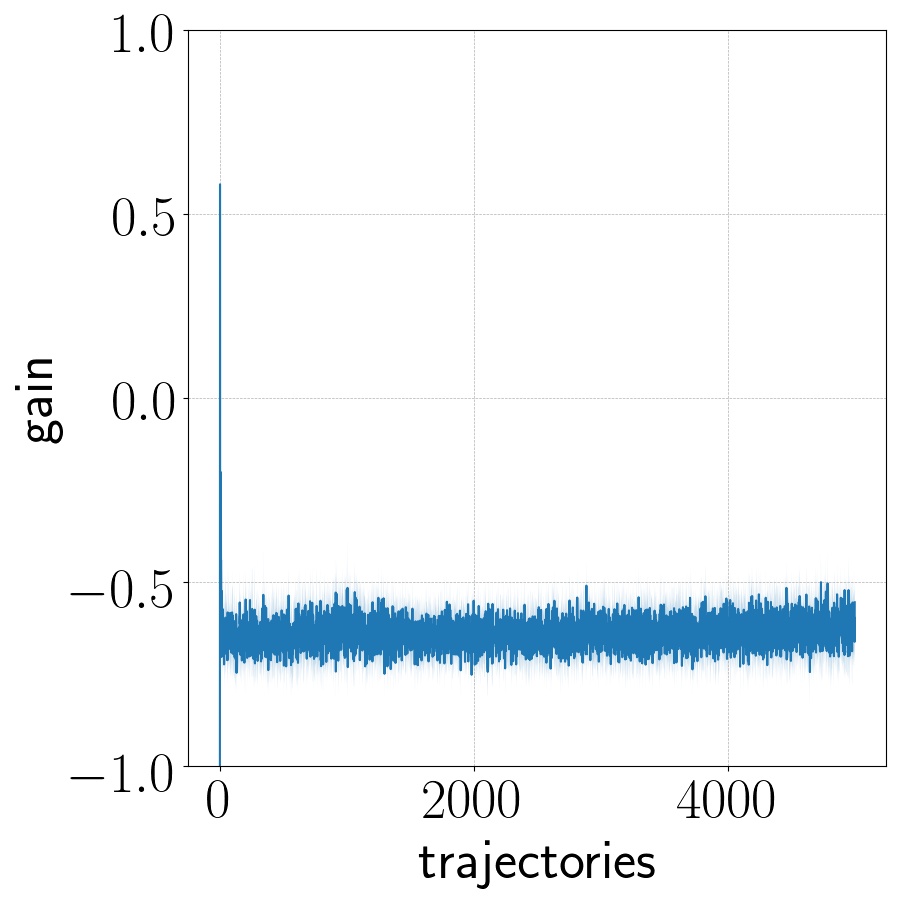

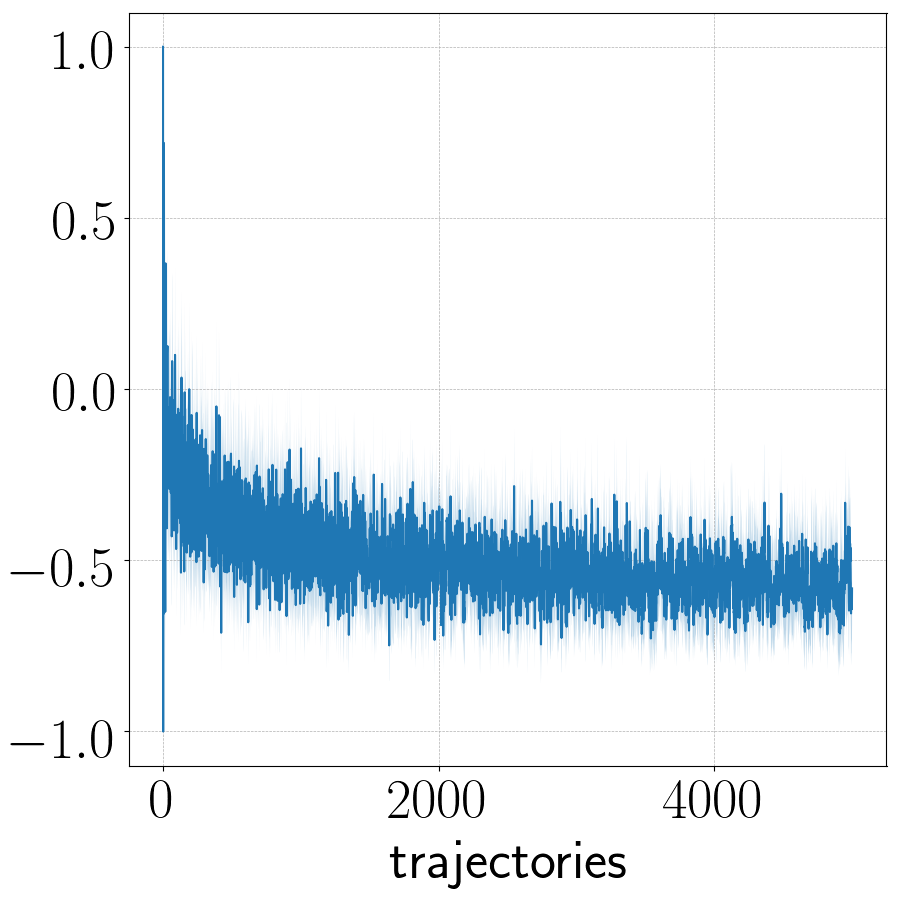

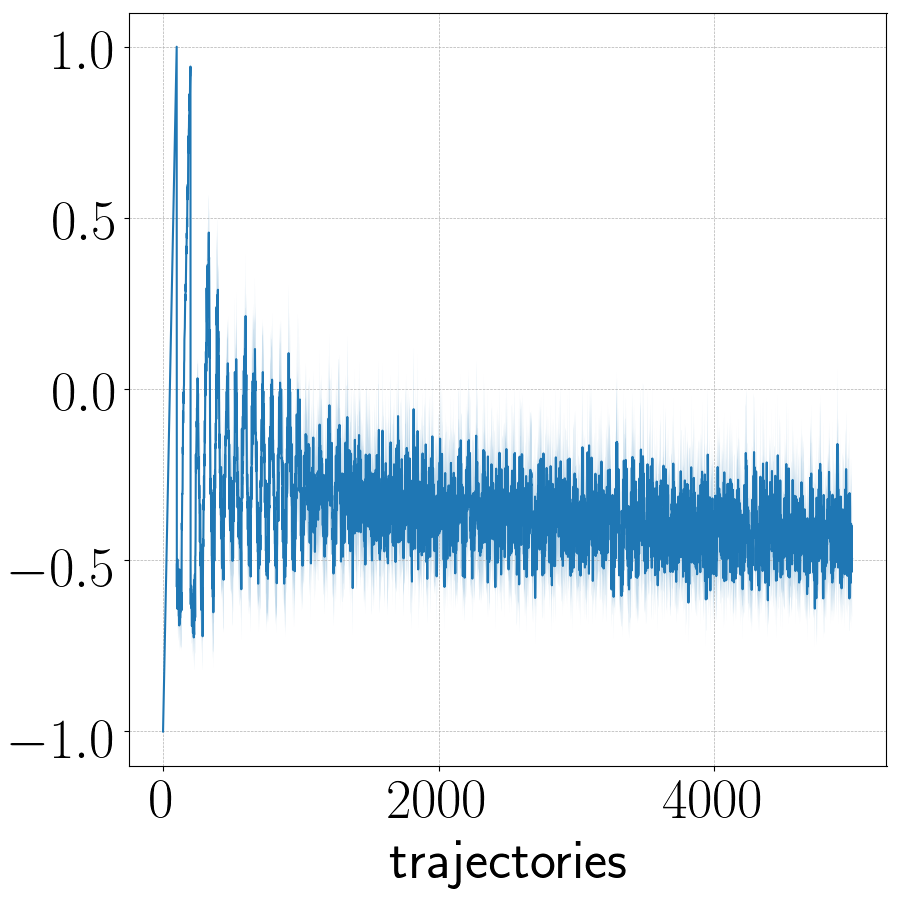

In [6]:
AXIS_FONT_SIZE=40
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'figure.autolayout': True})

fig_gpucb = plot_ci(dfs_list_gpucb, conf=0.95, key='mu', ylim=[-1,1], scale='Iteration', title='no', grid=True, xlabel='trajectories', ylabel='gain')
fig_opt = plot_ci(dfs_list_opt, conf=0.95, key='mu', ylim=None, scale='Iteration', title='no', grid=True, xlabel='trajectories', yticks=True)
fig_ucb1 = plot_ci(dfs_list_ucb1, conf=0.95, key='mu', ylim=None, scale='Iteration', title='no', grid=True, xlabel='trajectories', yticks=True)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
# save_plot(fig_gpucb, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQG_GPUCB_mu')
# save_plot(fig_opt, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQG_OPTIMIST_mu')
# save_plot(fig_ucb1, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQG_UCB1_mu')

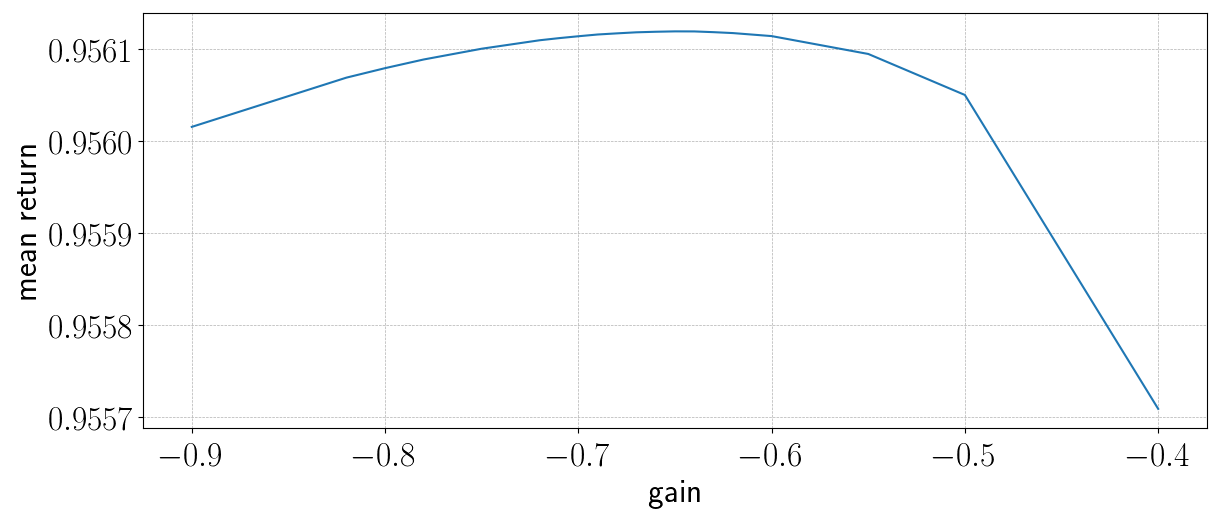

In [9]:
AXIS_FONT_SIZE=24
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [12, 5]

path ="./old/optimal_arm/optimal_arms_rescaled_return/LQG*"
dfs_list, filenames = read_csv(path)

# plot_all(dfs_list, key='LQGmu1_higher')

ret = []
gain = []
for df in dfs_list:
    ret.append(df['ReturnMean'].values[-1])
    gain.append(df['LQGmu1_higher'].values[-1])
df = pd.DataFrame({'gain':gain, 'ret':ret}).sort_values('gain')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('gain')
plt.ylabel('mean return')
ax.plot(df['gain'], df['ret'])
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQG_optimal_gain')

## Mu & std

GPUCB: 122.620989 ± 108.264553	[-11.807209, 257.049186]	 total horizon: 5000
UCB1: 646.074448 ± 155.701195	[452.745880, 839.403016]	 total horizon: 5000
OPTIMIST: 477.962016 ± 129.245400	[317.482657, 638.441375]	 total horizon: 5000


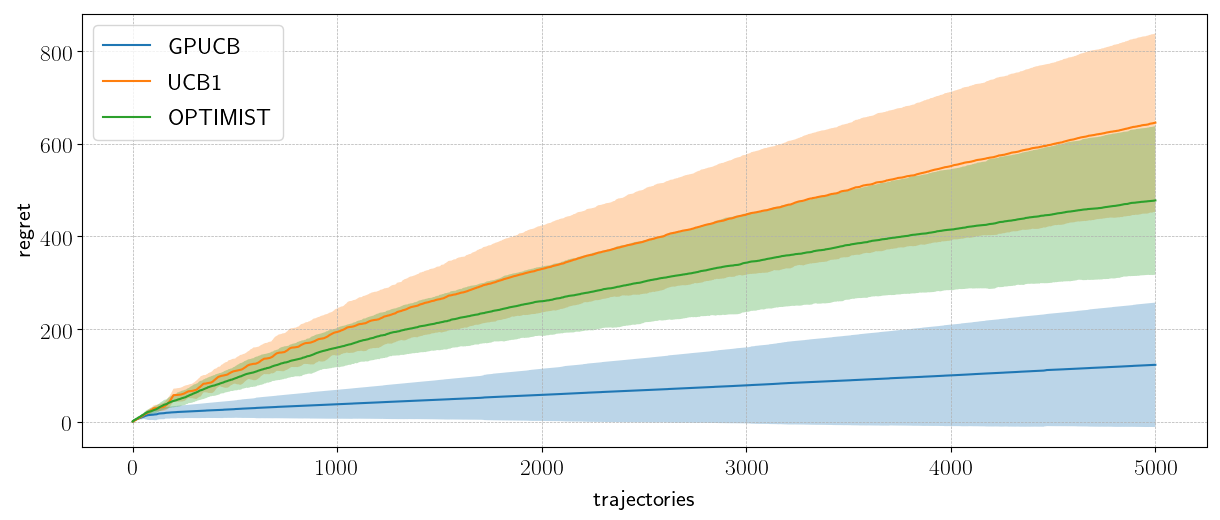

In [84]:
AXIS_FONT_SIZE=17
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [12, 5]

path_opt ="./paper_plots/optimist_lqg_std/L*"
path_gpucb ="./paper_plots/gpucb_lqg_std/g*"
path_ucb1 ="./paper_plots/ucb1_lqg_std/u*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
dfs_list_gpucb, filenames_gpucb = read_csv(path_gpucb)
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
candidates = {'OPTIMIST': dfs_list_opt, 'UCB1': dfs_list_ucb1, 'GPUCB': dfs_list_gpucb}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories', ylabel='regret')
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
# save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='LQGcomparisonVar')
# fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration', xlabel='trajectories')
# fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
# fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

# MountainCarContinuous-v0

OPTIMIST: 68.621549 ± 1.434329	[66.840594, 70.402504]	 total horizon: 5000
PGPE: 87.999884 ± 2.672706	[84.681280, 91.318487]	 total horizon: 50
PBPOIS: 81.021909 ± 7.190305	[72.093967, 89.949851]	 total horizon: 50


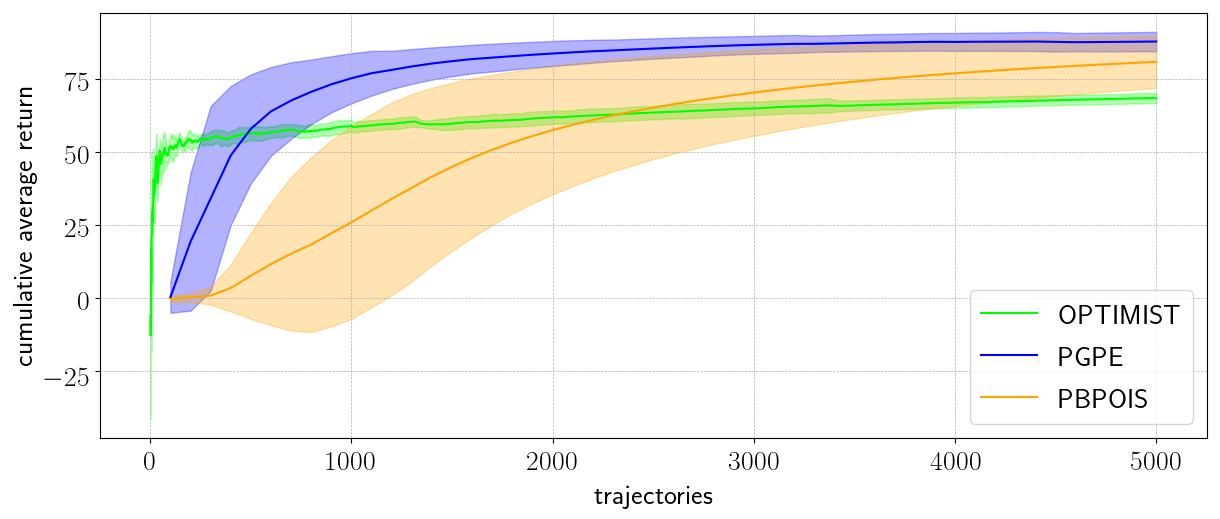

In [100]:
AXIS_FONT_SIZE=20
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [12, 5]

path_opt ="./paper_plots/optimist_mc/M*"
path_pgpe ="./paper_plots/pgpe_mc/MOUNTAINCARCONTINUOUS-V0_step=0.1*"
path_pbp ="./paper_plots/pbpois_mc/M*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
dfs_list_pgpe, filenames_pgpe = read_csv(path_pgpe)
dfs_list_pbp, filenames_pbp = read_csv(path_pbp)

candidates = OrderedDict()
candidates['OPTIMIST'] = dfs_list_opt
candidates['PGPE'] = dfs_list_pgpe
candidates['PBPOIS'] = dfs_list_pbp
# candidates = {'OPTIMIST': dfs_listà_opt, 'OPTIMIST_champagne': dfs_list_opt_ch, 'PGPE': dfs_list0}
fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories', legend_position='lower right', xlabel='trajectories', ylabel='cumulative average return')
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Presentation/Images', fname='MC_mu')

 dfs_list_opt[0]["TimeElapsed"].values[-1]/3600

## Heatmap - OPTIMIST

/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


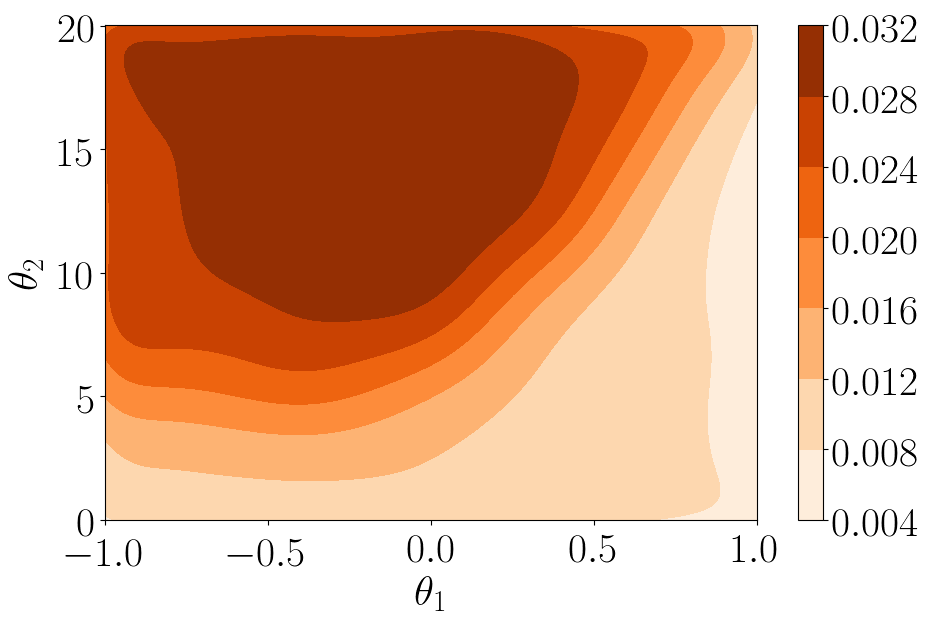

In [105]:
AXIS_FONT_SIZE=30
LINE_WIDTH=0.3
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'figure.autolayout': True})

# extract data to plot
path_opt ="./paper_plots/optimist_mc/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_13-30-13_2312019_14723.csv"
dfs_list_opt, filenames_opt = read_csv(path_opt)
df = dfs_list_opt[0].fillna(0)
x = df['MountainCar_mu0_higher'].values
y = df['MountainCar_mu1_higher'].values
data = np.array([x, y])

# perform kernel density estimation
kde = stats.gaussian_kde(data)
xx, yy = np.mgrid[-1:1.01:.01, 0:20.01:.01] # lower step size dimension to run faster
density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)

# plot the estimated density
f, ax = plt.subplots()
cset = ax.contourf(xx, yy, density, cmap="Oranges")
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
f.colorbar(cset)
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(f, dir='/home/lupol/dev/tesi/thesis/Presentation/Images', fname='MCgainOPTIMIST')

## Heatmap - PGPE

/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


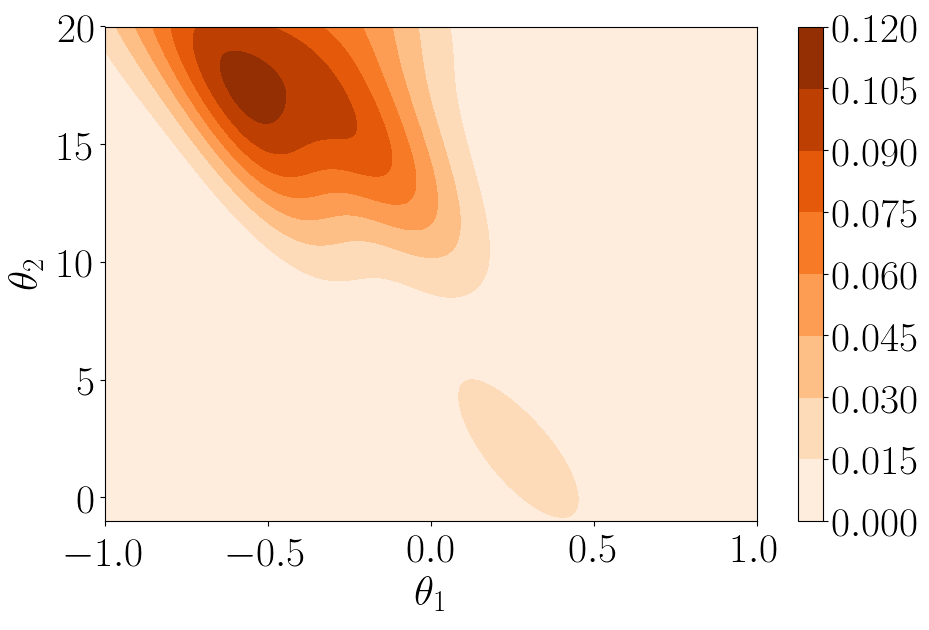

In [104]:
AXIS_FONT_SIZE=30
LINE_WIDTH=0.3
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'figure.autolayout': True})

# extract data to plot
path0 ="./paper_plots/pgpe_mc/MOUNTAINCARCONTINUOUS-V0_step=0.1_seed=0_11-21-16_2312019_27471.csv"
dfs_list0, filenames0 = read_csv(path0)
df = dfs_list0[0].fillna(0)
x = df['MountainCar_mu0_higher'].values
y = df['MountainCar_mu1_higher'].values
data = np.array([x, y])

# perform kernel density estimation
kde = stats.gaussian_kde(data)
xx, yy = np.mgrid[-1:1.01:.01, -1:20:.01] # lower step size dimension to run faster
density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)

# plot the estimated density
f, ax = plt.subplots()
cset = ax.contourf(xx, yy, density, cmap="Oranges")
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
f.colorbar(cset)
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(f, dir='/home/lupol/dev/tesi/thesis/Presentation/Images', fname='MCgainPGPE')

'\nfig, ax = plt.subplots(figsize=(5,5))\nh = sns.jointplot(ax=ax, x=x, y=y, kind=\'kde\', color="skyblue", marginal_kws={})\nh.set_axis_labels("\\xi_1", "\\xi2", fontsize=16)\nh.ax_joint.legend_.remove()\nplt.tight_layout(pad=0, w_pad=0, h_pad=0)\nsave_plot(fig, dir=\'./paper_figures/plots\', fname=\'heat1\')\n'

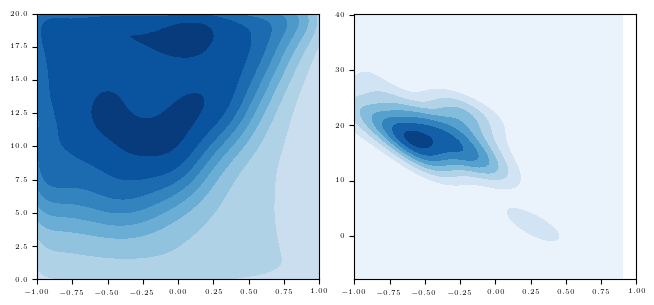

In [38]:
path_opt ="./paper_plots/optimist_mc/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_13-30-13_2312019_14723.csv"
dfs_list_opt, filenames_opt = read_csv(path_opt)
df = dfs_list_opt[0].fillna(0)
x = df['MountainCar_mu0_higher'].values
y = df['MountainCar_mu1_higher'].values

path0 ="./paper_plots/pgpe_mc/MOUNTAINCARCONTINUOUS-V0_step=0.1_seed=0_11-21-16_2312019_27471.csv"
dfs_list0, filenames0 = read_csv(path0)
xpgpe = dfs_list0[0]['MountainCar_mu0_higher'].values
ypgpe = dfs_list0[0]['MountainCar_mu1_higher'].values
# df = pd.DataFrame(data=dict(mu0=x, mu1=y)).fillna(0)
import seaborn as sns

AXIS_FONT_SIZE = 10
f, axes = plt.subplots(1, 2, figsize=(6.5,3), sharex=True, sharey=False)
# Create a cubehelix colormap to use with kdeplot

    # Generate and plot a random bivariate dataset
sns.kdeplot(x, y, shade=True, cmap="Blues", ax=axes[0])
axes[0].set(xlim=(-1, 1), ylim=(0, 20))

sns.kdeplot(xpgpe, ypgpe, shade=True, cmap="Blues",  ax=axes[1])
axes[0].set(xlim=(-1, 1), ylim=(0, 20))

# axes[0].set_xlabel("\\xi_1", fontsize=AXIS_FONT_SIZE)
# axes[0].set_ylabel("\\xi_2", fontsize=AXIS_FONT_SIZE)
# axes[0].set_title("OPTIMIST", fontsize=AXIS_FONT_SIZE)
# axes[1].set_xlabel("\\xi_1", fontsize=AXIS_FONT_SIZE)
# axes[1].set_ylabel("\\xi_2", fontsize=AXIS_FONT_SIZE)
# axes[1].set_title("PGPE", fontsize=AXIS_FONT_SIZE)

#cbar_ax = hexplot.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height

plt.tight_layout()#(pad=0, w_pad=0, h_pad=0)
save_plot(f, dir='./paper_figures/plots', fname='heat')
'''
fig, ax = plt.subplots(figsize=(5,5))
h = sns.jointplot(ax=ax, x=x, y=y, kind='kde', color="skyblue", marginal_kws={})
h.set_axis_labels("\\xi_1", "\\xi2", fontsize=16)
h.ax_joint.legend_.remove()
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='./paper_figures/plots', fname='heat1')
'''

## Inverted Pendulum

In [31]:
len(dfs_list_opt)

1

/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


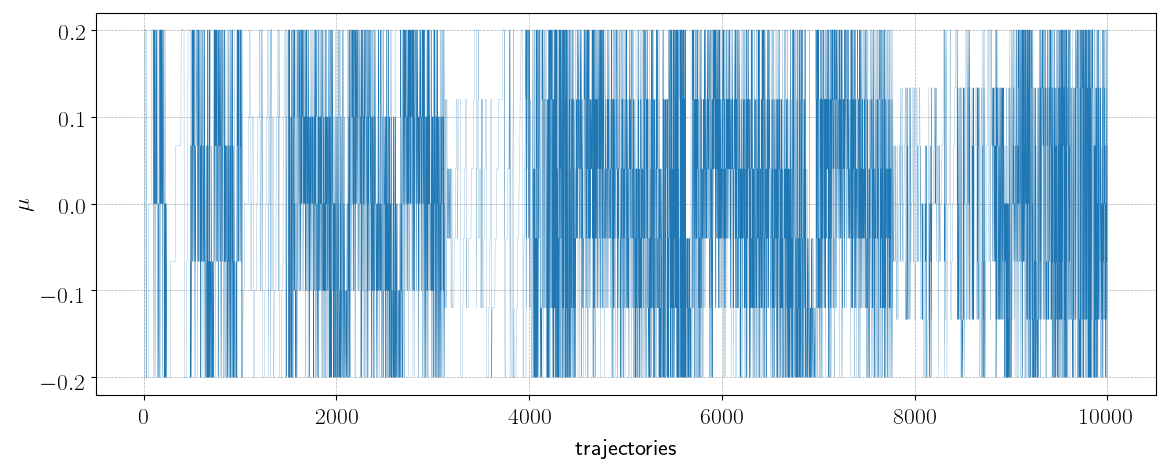

In [11]:
path_opt ="./paper_figures/continuous_setting/mu/ip/optimist_experiment_ip_k5_10000it_std01/R*"
dfs_list_opt, _ = read_csv(path_opt)
dfs_list_opt = list(map(lambda x: x.fillna(0), dfs_list_opt))
dfs_list_opt = rename_column('InvPendulum_mu1_higher', 'mu', [dfs_list_opt])[0]

AXIS_FONT_SIZE=17
LINE_WIDTH = 0.15
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('trajectories')
plt.ylabel('$\mu$')
ax.plot(dfs_list_opt[1]['Iteration'], dfs_list_opt[1]['mu'], linewidth=LINE_WIDTH)
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
# save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='IP_mu_1')

/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


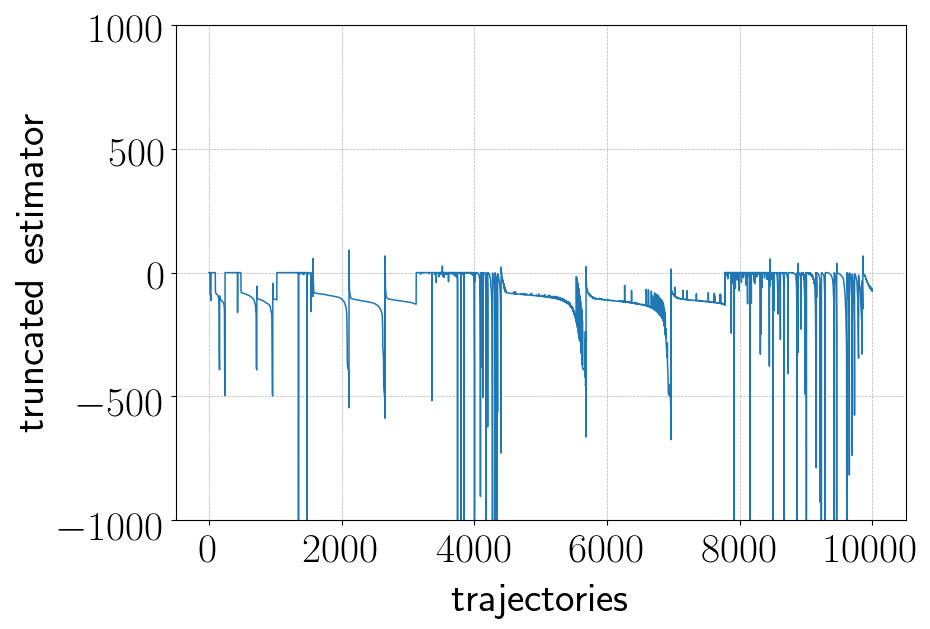

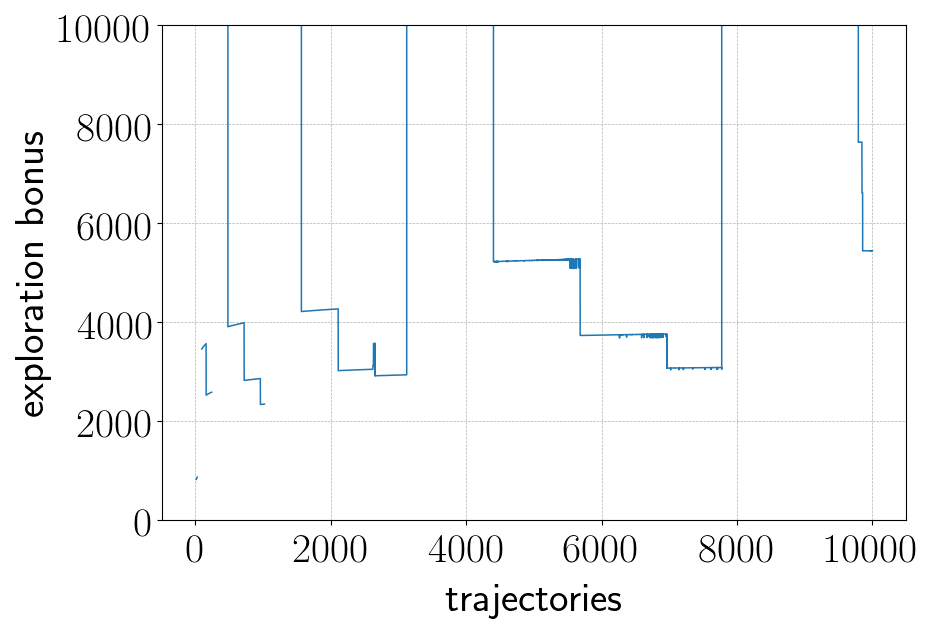

In [15]:
AXIS_FONT_SIZE=30
LINE_WIDTH=1.1
plt.close('all')
plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', size=AXIS_FONT_SIZE)
plt.rc('legend', fontsize=AXIS_FONT_SIZE)
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'figure.autolayout': True})

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('trajectories')
plt.ylabel('truncated estimator')
ax.plot(dfs_list_opt[1]['Iteration'], dfs_list_opt[1]['BoundMISE'], linewidth=LINE_WIDTH)
plt.ylim([-1000,1000])
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='IPmise')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('trajectories')
plt.ylabel('exploration bonus')
ax.plot(dfs_list_opt[1]['Iteration'], dfs_list_opt[1]['BoundBonus'], linewidth=LINE_WIDTH)
plt.ylim([0, 10000])
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
save_plot(fig, dir='/home/lupol/dev/tesi/thesis/Images', fname='IPbonus')

/home/lupol/.local/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


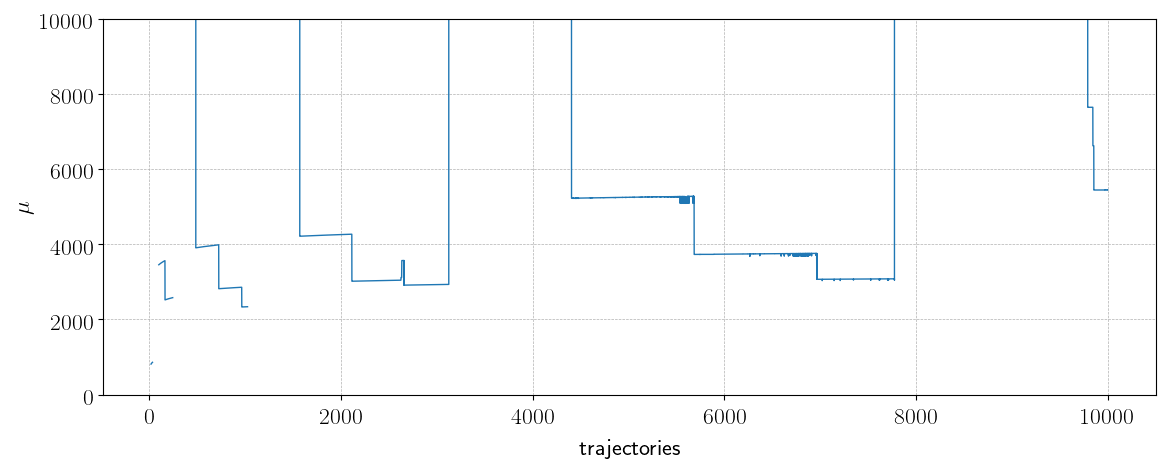

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.grid(linestyle='--', linewidth=0.5)
plt.xlabel('trajectories')
plt.ylabel('$\mu$')
ax.plot(dfs_list_opt[1]['Iteration'], dfs_list_opt[1]['BoundBonus'], linewidth=LINE_WIDTH)
plt.ylim([0, 10000])
plt.locator_params(axis='x', nbins=6)
plt.tight_layout(pad=0, w_pad=0, h_pad=0)